In [1]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm
from collections import Counter
import matplotlib
import matplotlib.patheffects as PathEffects
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re
from svgpathtools import parse_path
import svgpathtools

from PIL import Image
import base64
import sys

from svgpathtools import parse_path
from IPython.display import clear_output



import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")




In [2]:
# directory & file hierarchy
proj_dir = os.path.abspath('../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
features_dir= os.path.join(results_dir,'features')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))

if not os.path.exists(results_dir):
    os.makedirs(results_dir)  

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)  

if not os.path.exists(features_dir):
    os.makedirs(features_dir)
    
## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis'))        
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/kushin/Documents/GitHub/semantic_parts/analysis/analysis_helpers.pyc'>

In [3]:
## helper dictionaries 
OBJECT_TO_CATEGORY = {
    'basset': 'dog', 'beetle': 'car', 'bloodhound': 'dog', 'bluejay': 'bird',
    'bluesedan': 'car', 'bluesport': 'car', 'brown': 'car', 'bullmastiff': 'dog',
    'chihuahua': 'dog', 'crow': 'bird', 'cuckoo': 'bird', 'doberman': 'dog',
    'goldenretriever': 'dog', 'hatchback': 'car', 'inlay': 'chair', 'knob': 'chair',
    'leather': 'chair', 'nightingale': 'bird', 'pigeon': 'bird', 'pug': 'dog',
    'redantique': 'car', 'redsport': 'car', 'robin': 'bird', 'sling': 'chair',
    'sparrow': 'bird', 'squat': 'chair', 'straight': 'chair', 'tomtit': 'bird',
    'waiting': 'chair', 'weimaraner': 'dog', 'white': 'car', 'woven': 'chair',
}
CATEGORY_TO_OBJECT = {
    'dog': ['basset', 'bloodhound', 'bullmastiff', 'chihuahua', 'doberman', 'goldenretriever', 'pug', 'weimaraner'],
    'car': ['beetle', 'bluesedan', 'bluesport', 'brown', 'hatchback', 'redantique', 'redsport', 'white'],
    'bird': ['bluejay', 'crow', 'cuckoo', 'nightingale', 'pigeon', 'robin', 'sparrow', 'tomtit'],
    'chair': ['inlay', 'knob', 'leather', 'sling', 'squat', 'straight', 'waiting', 'woven'],
}

In [4]:
##helpers

def cleanup_df(X):
    if 'Unnamed: 0' in X.columns:
        X = X.drop(columns=['Unnamed: 0'])
    return X

def flatten(x):
    return [item for sublist in x for item in sublist]

def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X
def entropy(probs):    
    return - 1 * sum(map(lambda x: x * np.log(x),probs))

def KL_div_uniform(probs):
    unif_p = 1/len(probs)
    return sum(map(lambda x: unif_p * np.log(unif_p/x),probs))

def softmax(X):
    '''
    input: X is a (1 x N) array
    output: 1 x N array
    '''
    return np.exp(X)/np.sum(np.exp(X))

def minmaxscale(X):

    return (X-np.min(X))/(np.max(X)-np.min(X))

def calculate_CI(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m.round(3), (m-h).round(3), (m+h).round(3)

def get_ordered_objs_list_by_category(F):
    objs_list = []
    close_inds = F['condition'] == 'closer'
    far_inds = F['condition'] == 'further'
    categories = ['bird','car','chair','dog']
    for this_category in categories:
        category_inds = F['category'] == this_category
        objs_list.append(list(F[(category_inds) & (far_inds)].reset_index(drop=True).target.values))
    return flatten(objs_list)


def aggregate_sketches(F,OBJECT_TO_CATEGORY=OBJECT_TO_CATEGORY):
    '''
    F is full num sketches x num features matrix
    OBJECT_TO_CATEGORY is a dictionary that maps from object to category
    '''
    ## aggregate by target and condition and take the mean across rows within each group
    F2 = F.groupby(['target','condition']).mean().reset_index()

    ## re-add category back to the F dataframe so we can subset on that later 
    ##( taking mean above removes it b/c it is a string)
    F2['category'] = F2['target'].apply(lambda x: OBJECT_TO_CATEGORY[x])    
    
    return F2

def resample_sketches(F0,
                      groupby=['target','condition'],
                      random_state=0):    
    Fboot = F0.groupby(groupby).apply(lambda x: x.sample(n=len(x), replace=True, random_state=random_state))
    cols = Fboot.columns
    Fboot = Fboot.xs(cols, axis=1, drop_level=True).reset_index(drop=True)
    return Fboot

def get_context_difference_mat(F2):
    to_inspect = 'category'
    categories = ['bird','car','chair','dog']
    d = []
    for i, this_category in enumerate(categories):
        c,f, obj_listc, obj_listf = subset_dataframe_by_condition(F2,
                                            to_inspect=to_inspect,
                                            this_category=this_category) ## get subset of features

        _d = c.sub(f)
        if len(d)==0:
            d = _d
        else:
            d = pd.concat((d,_d),axis=0) 
    return d

def get_sparsity(vec):
    '''
    see: https://math.stackexchange.com/questions/117860/how-to-define-sparseness-of-a-vector
    maximally sparse = 1
    minimally sparse = 0
    '''
    k = len(vec)
    L1norm = np.linalg.norm(vec,ord=1)
    L2norm = np.linalg.norm(vec,ord=2)
    s = (np.sqrt(k) - (L1norm/L2norm))/(np.sqrt(k) - 1)
    return s

def subset_dataframe_by_condition(F,to_inspect='all',this_category='dog',this_object='pug'):
    '''
    input: F: dataframe (num_sketches x num_features)
           to_inspect: a string indicating whether to subset by ['object','category','all']
           this_category: IF to_inspect == 'category', then we define this to subset by that category only
           this_object: IF to_inspect == 'object', then we define this to subset by that object only
           
    returns: two feature matrices, c and f, corresponding to the close and far subsetted feature matrices
           
    '''
        
    ## ADD THIS LINE: sort F by category and object
    F = F.sort_values(by=['category','target'])

    ## get context condition inds for subsetting dataframe
    close_inds = F['condition'] == 'closer'
    far_inds = F['condition'] == 'further'

    ## if we want to inspect particular category
    category_inds = F['category']==this_category

    ## if we want to inspect particular object
    obj_list = np.unique(F.target.values)
    obj_inds = F['target']==this_object  
    
    ## get names of columns that contain stroke-count & arclength information
    numstrokes_cols = [i for i in F.columns if i.split('_')[-1]=='numstrokes']
    arclength_cols = [i for i in F.columns if i.split('_')[-1]=='arclength']
    feat_cols = numstrokes_cols + arclength_cols
    
    if to_inspect == 'object':    
        ## extract particular row corresponding to this OBJECT in each condition
        f = F[(far_inds) & obj_inds][feat_cols].reset_index(drop=True)
        c = F[(close_inds) & obj_inds][feat_cols].reset_index(drop=True)
        obj_listf = F[(far_inds) & obj_inds]['target'].values
        obj_listc = F[(close_inds) & obj_inds]['target'].values
    elif to_inspect == 'category':
        ## extract particular rows corresponding to this CATEGORY in each condition
        f = F[(category_inds) & (far_inds)][feat_cols].reset_index(drop=True)
        c = F[(category_inds) & (close_inds)][feat_cols].reset_index(drop=True)
        obj_listf = F[(category_inds) & (far_inds)]['target'].values
        obj_listc = F[(category_inds) & (close_inds)]['target'].values
    elif to_inspect == 'all':
        ## extract particular rows corresponding to each condition
        f = F[far_inds][feat_cols].reset_index(drop=True)
        c = F[close_inds][feat_cols].reset_index(drop=True) 
        obj_listf = F[far_inds]['target'].values
        obj_listc = F[close_inds]['target'].values
        
    return c, f, obj_listc, obj_listf

In [5]:
#Load in annotated sketch dataset| subsetted for sketches with 3 annotations
D=cleanup_df(pd.read_pickle(os.path.join(csv_dir, 'semantic_parts_annotated_data_pckl')))
D.shape

(58947, 28)

## Creating spline and stroke level dataframes for further analysis

In [6]:
## get the list of unique labels applied to sketches
unique_labels = np.unique(D.label.values)

## Removing Nones and obviously wrong super long lables
unique_labels = [i for i in unique_labels if i is not None]
unique_labels = [i for i in unique_labels if len(i)<900]

print 'we have {} unique labels'.format(len(unique_labels))

we have 24 unique labels


In [7]:
unique_cats= np.unique(D['category'])
##Create empty dictionary with categories as keys. We will use this to store part occurrence data for our categories
label_vect_dict = {unique_cats[0]:None,unique_cats[1]:None,unique_cats[2]:None,unique_cats[3]:None}

In [8]:
##Create vectors that contain the number of part instances in each sketch
num_annots=3

for category in unique_cats:
    DS= D[D['category']==category]
    unique_sketches_in_cat = np.unique(DS['sketch_id'])
    unique_labels_in_cat = np.unique(DS['label'])
    ## initialize matrix that has the correct dimensions
    Label_Vec = np.zeros((len(unique_sketches_in_cat),len(unique_labels_in_cat)), dtype=int)
    unique_labels_in_cat= np.array(unique_labels_in_cat)
    for s,this_sketch in enumerate(unique_sketches_in_cat):
        label_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        DSS = DS[DS['sketch_id']==this_sketch]
        annotation_ids = np.unique(DSS['annotation_id'].values)    
        for this_annotation in annotation_ids:
            DSA = DSS[DSS['annotation_id']==this_annotation]
            label_list = DSA.label.values
            for this_label in label_list:
                label_ind = unique_labels_in_cat==this_label
                label_vec[label_ind] += 1
            
        Label_Vec[s,:]=label_vec/num_annots
    label_vect_dict[category]= Label_Vec

In [9]:
valid_labels=[]
valid_labels_dict={}
for category in unique_cats:
    vect = label_vect_dict[category]
    thresh = 50
    #print 'These are the labels that appear at least {} times:'.format(thresh)
    #print unique_labels[np.sum(Label_Vec,0)>thresh]
    unique_labels_in_cat = np.unique(D[D['category']==category]['label'])
    plot_labels= unique_labels_in_cat[np.sum(vect,0)>thresh]
    valid_labels_dict[category]=plot_labels
    valid_labels.append(plot_labels)


    prop_labels=[]
    for part in plot_labels:
        DS=D[D['category']==category]
        prop_labels.append(DS[DS['label']==part]['annotation_id'].nunique()/DS['annotation_id'].nunique())
    
    
#     sns.set_context('talk')
#     plt.figure(figsize=(12,7))
#     plt.ylim(0,1)
#     h = plt.bar(plot_labels,prop_labels)
#     plt.title('Proportion of {} annotations with labels'.format(category))
#     plt.ylabel('proportion of annotations')
#     plt.xlabel('Part')
    
##flattening valid labels
valid_labels = [item for sublist in valid_labels for item in sublist]


In [10]:
#Creating a spline-level df where the modal label is set as the 'true' label for any given spline
spline_df= D.groupby('spline_id').agg(lambda x: Counter(x).most_common(1)[0][0])
spline_df.reset_index(level=0, inplace=True)

In [11]:
##Creating a stroke-level dataframe that takes the mode value of annotation for its children splines to set as its
##label value

from collections import Counter


from collections import OrderedDict
stroke_svgs=OrderedDict()
for category in unique_cats:
    DS=D[D['category']==category]
    for sketch in np.unique(DS['sketch_id']):
        DSS=DS[DS['sketch_id']==sketch]
        for stroke in np.unique(DSS['stroke_num']):
            DSA=DSS[DSS['stroke_num']==stroke]
            DSA=DSA.reset_index()
            stroke_svgs[DSA['stroke_id'][0]] = DSA['sketch_svg_string'][0][stroke]

            
            
stroke_svg_df= pd.DataFrame.from_dict(stroke_svgs, orient='index')    
stroke_group_data= D.groupby('stroke_id').agg(lambda x: Counter(x).most_common(1)[0][0])
labels= pd.DataFrame(stroke_group_data[['sketch_id','label','stroke_num','condition','target','category','outcome']])
stroke_df=pd.merge(stroke_svg_df,labels,left_index=True, right_index =True)
stroke_df.reset_index(level=0, inplace=True)
stroke_df=stroke_df.rename(index=str, columns={"index": "stroke_id", 0: "svg"})


In [12]:
##Adding total arclength information to stroke dataframe

def calculate_arclength(svg):
    try:
        arclength= parse_path(svg).length()
    except ZeroDivisionError:
        print 'zero div error'
        arclength = 0
    return arclength
        
                    

In [13]:
stroke_df['arc_length'] = stroke_df['svg'].apply(calculate_arclength)

### Inter-annotator reliability

In [14]:
## Getting the number of unique labels assigned to a given spline across annotations
a=[]
num_diff_annots = []
for this_cat in unique_cats:
    DS=D[D['category']==this_cat]
    labels = valid_labels_dict[this_cat]
    unique_sketches_in_cat=np.unique(DS['sketch_id'])
    

   
    for this_sketch_id in unique_sketches_in_cat:
        DSA=DS[DS['sketch_id']==this_sketch_id]
        unique_splines = np.unique(DSA['cumulative_spline_num'])
        for i,this_spline in enumerate(unique_splines):
            DSB =DSA[DSA['cumulative_spline_num']==this_spline]
            numannots= 4-len(np.unique(DSB['label']))
            if len(np.unique(DSB['label'])) == 3:
                a.append(this_sketch_id)
            if numannots==0:
                numannots=1
            num_diff_annots.append(numannots)

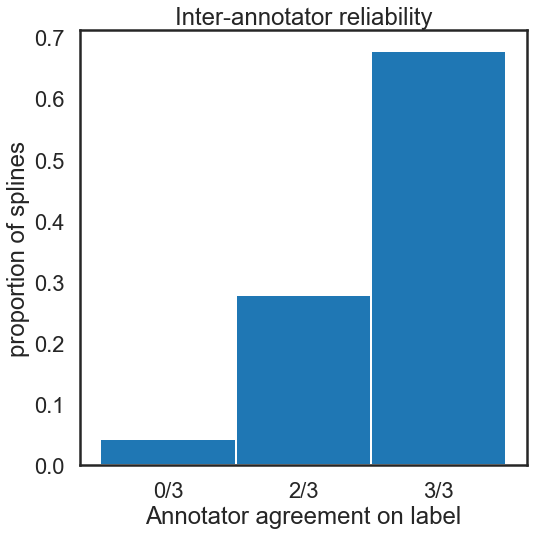

In [15]:
#plotting variability in spline annots
plt.figure(figsize=(8,8))
plt.hist(num_diff_annots, bins= range(1,5), align='left', density='True')
plt.title('Inter-annotator reliability')
plt.ylabel('proportion of splines')
plt.xlabel('Annotator agreement on label')
plt.xticks([1,2,3],['0/3','2/3','3/3'])
plt.show()

### Stroke-part relationships

In [16]:
spline_dfs = spline_df
stroke_dfs = stroke_df
spline_annots_per_stroke = []
for this_cat in unique_cats:
    labels = valid_labels_dict[this_cat]
    DS=spline_dfs[spline_dfs['category']==this_cat]
    unique_sketches_in_cat= np.unique(DS['sketch_id'])
    for this_sketch_id in unique_sketches_in_cat:
        DSA=DS[DS['sketch_id']==this_sketch_id]
        unique_strokes = np.unique(DSA['stroke_num'])
        for i,this_stroke in enumerate(unique_strokes):
            DSB =DSA[DSA['stroke_num']==this_stroke]
            numlabels= DSB['label'].nunique()
            spline_annots_per_stroke.append(numlabels)
h= plt.hist(spline_annots_per_stroke, bins =[1,2,3,4,5,6], align='left', density="True", color='grey')
pps_series = pd.Series(np.array([h[0][0],h[0][1],h[0][2:].sum()]), index=['1', '2', '3+'], \
                     )

strokes_per_part = []
for this_cat in unique_cats:
    DS=stroke_dfs[stroke_dfs['category']==this_cat]
    unique_sketches_in_cat= np.unique(DS['sketch_id'])
    for this_sketch_id in unique_sketches_in_cat:
        DSA=DS[DS['sketch_id']==this_sketch_id]
        parts_in_sketch = np.unique(DSA['label'])
        for i,this_part in enumerate(parts_in_sketch):
            DSB =DSA[DSA['label']==this_part]
            numstrokes= DSB['stroke_num'].nunique()
            strokes_per_part.append(numstrokes)
h= plt.hist(strokes_per_part, bins =[1,2,3,4,5,6,7,8,9,10], align='left', density="True", color ='grey')
spp_series = pd.Series(np.array([h[0][0],h[0][1],h[0][2:].sum()]), index=['1', '2', '3+'], \
                     )
plt.close()

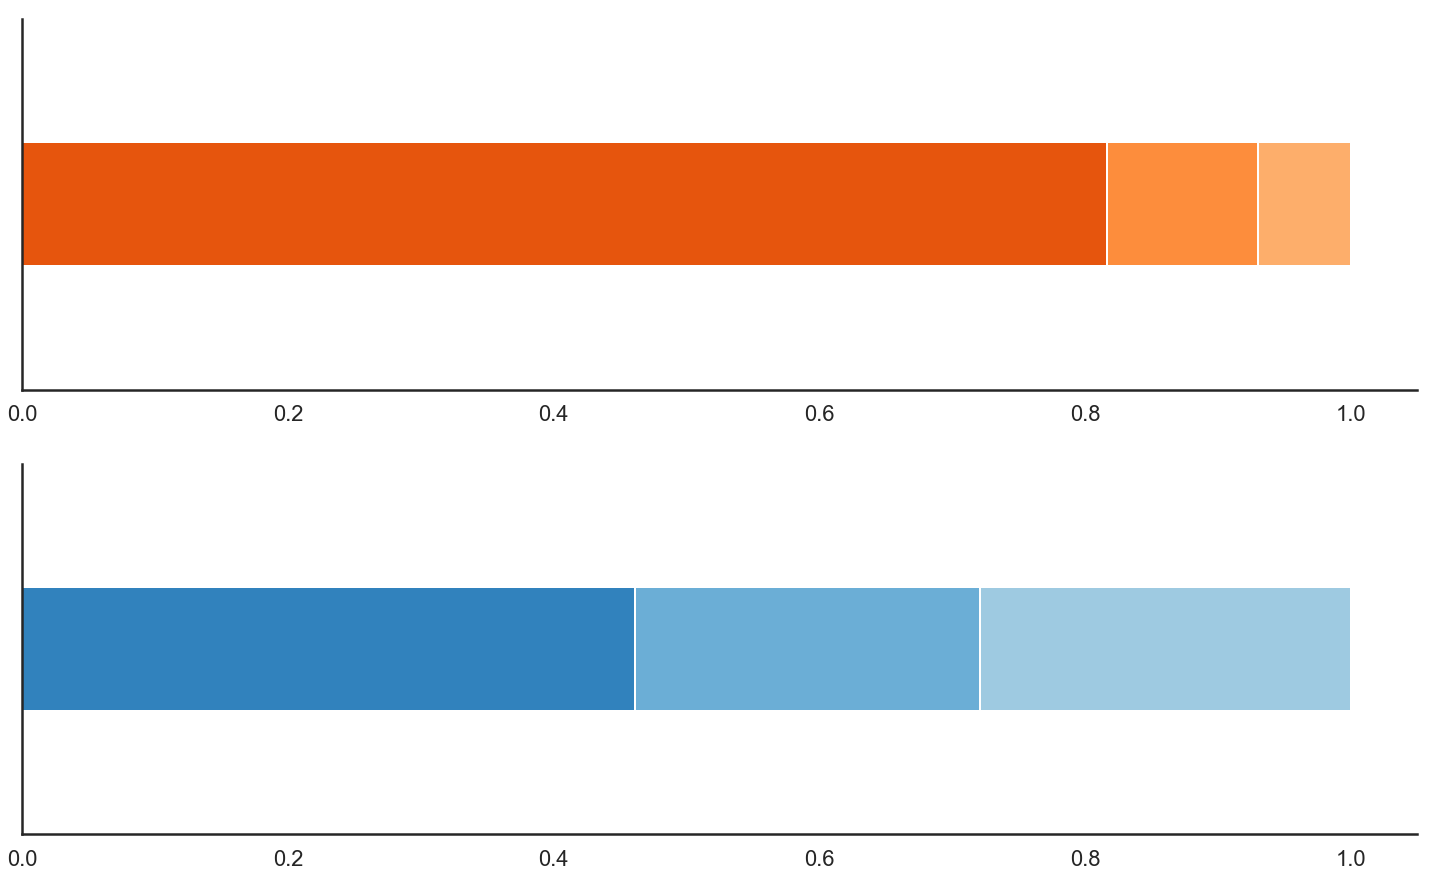

In [17]:
fig = plt.figure(figsize=(25,15))
colors = sns.color_palette('tab20c')

ax1 = fig.add_subplot(212) # Create matplotlib axes
ax2 = fig.add_subplot(211)


# pd.DataFrame(spp_series).T.plot(ax=axes[0,1]).bar(stacked=True,legend=False, width =0.2)
# pd.DataFrame(pps_series).T.plot(ax=axes[0,0]).bar(stacked=True,legend=False, width =0.2)


b1=pd.DataFrame(spp_series).T.plot.barh(stacked=True,legend=False, width =0.25,ax=ax1, color=[colors[0],colors[1],colors[2]])
b2=pd.DataFrame(pps_series).T.plot.barh(stacked=True,legend=False, width =0.25,ax=ax2, color=[colors[4],colors[5],colors[6]])




for item in b1.get_xticklabels():
     item.set_rotation(0)

for item in b2.get_xticklabels():
     item.set_rotation(0)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.set_ylabel('')
ax2.set_ylabel('')
ax1.set_xlabel('',labelpad = 15)
ax2.set_xlabel('',labelpad= 15)
ax1.set_yticks([])
ax2.set_yticks([])
plt.subplots_adjust(wspace=1)



#plt.savefig(os.path.join(plot_dir,'stroke_part_relationship'),edgecolor='w',bbox_inches='tight',dpi=500)



In [116]:
from collections import Counter
iters=5
c_pps=[]
f_pps=[]
c_spp=[]
f_spp=[]
for this_cond in np.unique(D.condition):
    for i in range(iters):
        spline_dfs = spline_df[spline_df['condition']==this_cond]
        stroke_dfs = stroke_df[stroke_df['condition']==this_cond]
        spline_annots_per_stroke = []


        unique_sketches_in_cond= np.unique(spline_dfs['sketch_id'])
        sample_sketches = np.random.choice(unique_sketches_in_cond,len(unique_sketches_in_cond),replace=True)
        for this_sketch_id in sample_sketches:
            DSA=spline_dfs[spline_dfs['sketch_id']==this_sketch_id]
            unique_strokes = np.unique(DSA['stroke_num'])
            for i,this_stroke in enumerate(unique_strokes):
                DSB =DSA[DSA['stroke_num']==this_stroke]
                numlabels= DSB['label'].nunique()
                spline_annots_per_stroke.append(numlabels)

        h= np.array(Counter(spline_annots_per_stroke).values())    
        pps_series = np.array([h[0],h[1],h[2:].sum()])
        if this_cond=='closer':
            c_pps.append(pps_series)
        elif this_cond == 'further':
            f_pps.append(pps_series)



        strokes_per_part = []

        unique_sketches_in_cond= np.unique(stroke_dfs['sketch_id'])
        sample_sketches = np.random.choice(unique_sketches_in_cond,len(unique_sketches_in_cond),replace=True)
        for this_sketch_id in sample_sketches:
            DSA=stroke_dfs[stroke_dfs['sketch_id']==this_sketch_id]
            parts_in_sketch = np.unique(DSA['label'])
            for i,this_part in enumerate(parts_in_sketch):
                DSB =DSA[DSA['label']==this_part]
                numstrokes= DSB['stroke_num'].nunique()
                strokes_per_part.append(numstrokes)
        h= np.array(Counter(strokes_per_part).values())    
        spp_series = np.array([h[0],h[1],h[2:].sum()])
        if this_cond=='closer':
            c_spp.append(spp_series)
        elif this_cond == 'further':
            f_spp.append(spp_series)

c_pps=np.vstack(c_pps)

f_pps=np.vstack(f_pps)

c_spp=np.vstack(c_spp)

f_spp=np.vstack(f_spp)

In [118]:
# c_pps= np.load(os.path.join(features_dir,'c_pps.npy'))
c_pps = c_pps/c_pps.sum(axis=1)[:,None]
# c_spp= np.load(os.path.join(features_dir,'c_spp.npy'))
c_spp = c_spp/c_spp.sum(axis=1)[:,None]
# f_pps= np.load(os.path.join(features_dir,'f_pps.npy'))
f_pps = f_pps/f_pps.sum(axis=1)[:,None]
# f_spp= np.load(os.path.join(features_dir,'f_spp.npy'))
f_spp = f_spp/f_spp.sum(axis=1)[:,None]


c_pps[:,1]=c_pps[:,1]+c_pps[:,2]
c_pps=np.delete(c_pps,2,1)
f_pps[:,1]=f_pps[:,1]+f_pps[:,2]
f_pps=np.delete(f_pps,2,1)



c_spp[:,1]=c_spp[:,1]+c_spp[:,2]
c_spp=np.delete(c_spp,2,1)
f_spp[:,1]=f_spp[:,1]+f_spp[:,2]
f_spp=np.delete(f_spp,2,1)


In [119]:
#Parts per stroke

c_pps_CI = np.percentile(c_pps[:,1],2.5).round(3),np.percentile(c_pps[:,1],97.5).round(3)
f_pps_CI = np.percentile(f_pps[:,1],2.5).round(3),np.percentile(f_pps[:,1],97.5).round(3)
print c_pps_CI, f_pps_CI

(0.173, 0.182) (0.19, 0.212)


In [120]:
#Strokes per part

c_spp_CI = np.percentile(c_spp[:,1],2.5).round(3),np.percentile(c_spp[:,1],97.5).round(3)
f_spp_CI = np.percentile(f_spp[:,1],2.5).round(3),np.percentile(f_spp[:,1],97.5).round(3)
print c_spp_CI, f_spp_CI

(0.537, 0.576) (0.506, 0.528)


### Part-streak analysis

In [21]:
dataset = 'normalized'
##Creating a dictionary of sketch_id with associated part sequences
seq_dict={}
for this_sketch in np.unique(stroke_df['sketch_id']):
    parts_list=[]
    DS=stroke_df[stroke_df['sketch_id']==this_sketch]
    for i, row in DS.iterrows():
        parts_list.append(stroke_df['label'][i])
    seq_dict[this_sketch]=parts_list

In [22]:
##functions for getting 'mean streak_length' from a particular sketch for ground truth and scrambled part orders

import random

def get_mean_streak(sketch_id):
    parts = seq_dict[sketch_id]
    streak_counter=1
    list_of_streaks=[]
    for obj in range(len(parts)-1):
        if parts[obj]==parts[obj+1]:
            streak_counter+=1
        else:
            list_of_streaks.append(streak_counter)
            streak_counter=1 
    list_of_streaks.append(streak_counter)
    return np.mean(list_of_streaks)

def get_scramble_mean_streak(sketch_id):
    parts = seq_dict[sketch_id]
    scram_parts=random.sample(parts,len(parts))
    streak_counter=1
    list_of_streaks=[]
    for obj in range(len(scram_parts)-1):
        if scram_parts[obj]==scram_parts[obj+1]:
            streak_counter+=1
        else:
            list_of_streaks.append(streak_counter)
            streak_counter=1 
    list_of_streaks.append(streak_counter)
    return np.mean(list_of_streaks)

In [23]:
#Iterating over all sketches to get mean streakiness for each sketch_id

gt_streak_mean={}
for this_cat in unique_cats:
    DS= stroke_df[stroke_df['category']==this_cat]
    streak_mean_list=[]
    for this_sketch in np.unique(DS['sketch_id']):
        streak_mean_list.append(get_mean_streak(this_sketch))
    gt_streak_mean[this_cat]=np.mean(streak_mean_list)

In [24]:
##Creating a list of exception sketches
single_stroke_sketches=[]
single_label_sketches=[]
strokes_equal_labels_sketches=[]
for this_sketch in stroke_df.sketch_id.unique():
    stroke_df_s= stroke_df[stroke_df['sketch_id']==this_sketch]
    if stroke_df_s.stroke_num.nunique()==1:
        single_stroke_sketches.append(this_sketch)
    if stroke_df_s.label.nunique()==1:
        single_label_sketches.append(this_sketch)
    if stroke_df_s.label.nunique()== stroke_df_s.stroke_num.nunique():
        strokes_equal_labels_sketches.append(this_sketch)
ss_sketches_labels={}
sl_sketches_numstrokes={}
sel_sketches_labels={}
for this_sketch in single_stroke_sketches:
    ss_sketches_labels[this_sketch] = stroke_df[stroke_df['sketch_id']==this_sketch].label
for this_sketch in single_label_sketches:
    sl_sketches_numstrokes[this_sketch]=stroke_df[stroke_df['sketch_id']==this_sketch].stroke_num.nunique()
for this_sketch in strokes_equal_labels_sketches:
    sel_sketches_labels[this_sketch]=stroke_df[stroke_df['sketch_id']==this_sketch].label.unique()

    
_donotpermute=single_stroke_sketches + single_label_sketches + strokes_equal_labels_sketches
donotpermute=np.unique(_donotpermute).tolist()

In [25]:
##z-score of gt
#scrambled_higher_prop={}
gt_streak_zscore={}
true_streak_means = {}
permuted_streak_means = {}
for this_target in stroke_df.target.unique():
    DA=stroke_df[stroke_df['target']==this_target]
    for this_sketch in DA.sketch_id.unique():
        if this_sketch not in donotpermute:
            prop_counter=0
            intact_mean_streak = get_mean_streak(this_sketch)
            permuted_streak_list = []
            for i in range(1000):
                scrambled_mean_streak=get_scramble_mean_streak(this_sketch)
                permuted_streak_list.append(scrambled_mean_streak)
#                 if intact_mean_streak<scrambled_mean_streak:
#                     prop_counter+=1
            try:  
                assert np.isnan((get_mean_streak(this_sketch)-np.mean(permuted_streak_list))/np.std(permuted_streak_list)) == False
                true_streak_means[this_sketch] = get_mean_streak(this_sketch)
                permuted_streak_means[this_sketch] = np.mean(permuted_streak_list)
                gt_streak_zscore[this_sketch]=(get_mean_streak(this_sketch)-np.mean(permuted_streak_list))/np.std(permuted_streak_list)
            except AssertionError:
                print stroke_df[stroke_df.sketch_id==this_sketch].stroke_num.nunique(),stroke_df[stroke_df.sketch_id==this_sketch].label.nunique()
#             scrambled_higher_prop[this_sketch]=prop_counter/1000
            
            
            
            

In [26]:
tls=[]
objs=[]
cond=[]
cat=[]
for this_target in stroke_df.target.unique():
    DA=stroke_df[stroke_df['target']==this_target]
    _sketch_ids = DA.sketch_id.unique()
    _sketch_ids = [x for x in _sketch_ids if x not in donotpermute]
    true_streaks_sub=dict((k, true_streak_means[k]) for k in _sketch_ids)
    perm_streaks_sub = dict((k, permuted_streak_means[k]) for k in _sketch_ids)
    tls.append(true_streaks_sub.values())
    cond.append(["Intact"]*len(true_streaks_sub.values()))
    objs.append([this_target]*len(true_streaks_sub.values()))
    cat.append([OBJECT_TO_CATEGORY[this_target]]*len(true_streaks_sub.values()))
    
    tls.append(perm_streaks_sub.values())
    cond.append(["Scrambled"]*len(true_streaks_sub.values()))
    objs.append([this_target]*len(true_streaks_sub.values()))
    cat.append([OBJECT_TO_CATEGORY[this_target]]*len(true_streaks_sub.values()))
    

In [27]:
tls = [item for sublist in tls for item in sublist]
objs= [item for sublist in objs for item in sublist]
cond= [item for sublist in cond for item in sublist]
cat= [item for sublist in cat for item in sublist]
assert len(tls)==len(objs)==len(cond)==len(cat)

In [28]:
_data= { 'objects':objs,'Mean Streak Length':tls, "Condition":cond, "category":cat}
data= pd.DataFrame(data = _data)

colors = sns.color_palette("husl", 5)
C0=colors[0]
C1=colors[1]
C2=colors[2]
C3=colors[3]

/usr/local/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'')

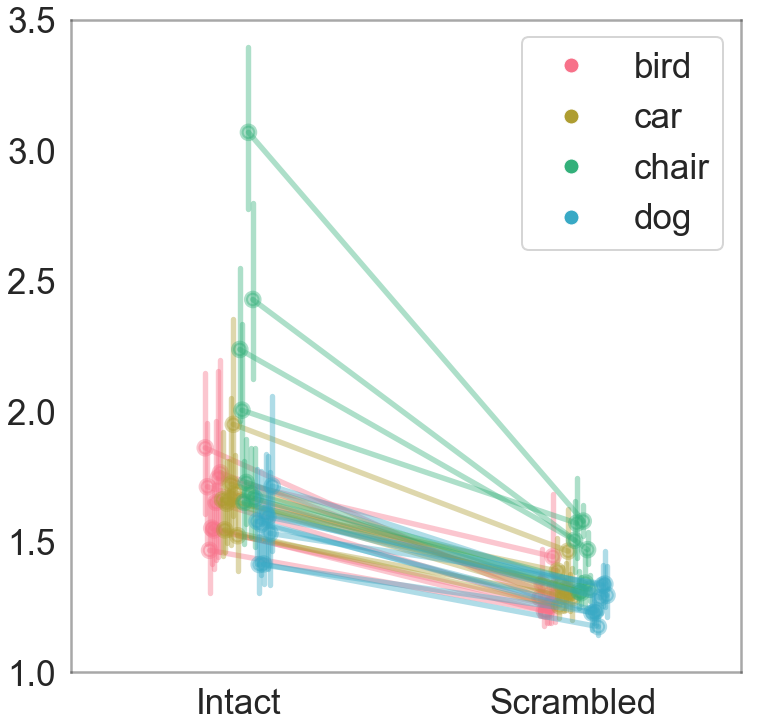

In [29]:
from matplotlib.lines import Line2D
palette= {
    'basset': C3, 'beetle': C1, 'bloodhound': C3, 'bluejay': C0,
    'bluesedan': C1, 'bluesport': C1, 'brown': C1, 'bullmastiff': C3,
    'chihuahua': C3, 'crow': C0, 'cuckoo': C0, 'doberman': C3,
    'goldenretriever': C3, 'hatchback': C1, 'inlay': C2, 'knob': C2,
    'leather': C2, 'nightingale': C0, 'pigeon': C0, 'pug': C3,
    'redantique': C1, 'redsport': C1, 'robin': C0, 'sling': C2,
    'sparrow': C0, 'squat': C2, 'straight': C2, 'tomtit': C0,
    'waiting': C2, 'weimaraner': C3, 'white': C1, 'woven': C2,
}


plt.figure(figsize=(12,12))

p = sns.pointplot(x="Condition", hue="objects", y= "Mean Streak Length",data=data,ci=95\
                  ,dodge= 0.2, palette = palette)
p.set(ylim=(1, 3.5))
plt.setp([p.get_children()[0],p.get_children()],alpha=0.4)

leg_elements = [Line2D([0], [0], marker='o', color='w', label='bird',
                          markerfacecolor=C0, markersize=15),
                Line2D([0], [0], marker='o', color='w', label='car',
                          markerfacecolor=C1, markersize=15),
                Line2D([0], [0], marker='o', color='w', label='chair',
                          markerfacecolor=C2, markersize=15),
                Line2D([0], [0], marker='o', color='w', label='dog',
                          markerfacecolor=C3, markersize=15),
               ]

plt.legend(handles= leg_elements, prop={'size': 35})
plt.tick_params(labelsize=35)
plt.xlabel('', fontsize=35)
plt.ylabel('', fontsize=35)
#plt.savefig(os.path.join(plot_dir,'streak_length_pp'),edgecolor='w',bbox_inches='tight',dpi=500)




#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [124]:
DA=D
_sketch_ids= DA.sketch_id.unique()
_sketch_ids = [x for x in _sketch_ids if x not in donotpermute]
z_scores_sub=dict((k, gt_streak_zscore[k]) for k in _sketch_ids)
plt.figure()
plt.title('Intact mean streak Z-score Distribution for all sketches')
h=sns.distplot(z_scores_sub.values(),kde=False,hist=True,norm_hist=False)
plt.close()
print 'mean and CI for all objs', calculate_CI(z_scores_sub.values())

##broken out by condition
for this_cond in stroke_df.condition.unique():
    DA=stroke_df[stroke_df['condition']==this_cond]
    _sketch_ids= DA.sketch_id.unique()
    _sketch_ids = [x for x in _sketch_ids if x not in donotpermute]
    z_scores_sub=dict((k, gt_streak_zscore[k]) for k in _sketch_ids)
    plt.figure()
    plt.title('Intact mean streak Z-score Distribution for {}'.format(this_cond))
    h=sns.distplot(z_scores_sub.values(),kde=False,hist=True,norm_hist=False)
    plt.close()
    print 'Intact and CI for {} condition'.format(this_cond), calculate_CI(z_scores_sub.values())

mean and CI for all objs (2.068, 1.898, 2.238)
Intact and CI for closer condition (2.588, 2.294, 2.883)
Intact and CI for further condition (1.616, 1.438, 1.795)


## Creating feature vectors and normalizing 

In [125]:
###This is where we make a num unique labels * 2 X number of sketches vector 

feature_vec = np.zeros((len(stroke_df.sketch_id.unique()),len(valid_labels)*2), dtype=int)
ind=0
start_pos=0
end_pos=0
meta_list=[]
cols = ['sketch_id','target','condition','category','outcome']

for cat in unique_cats:
  
    DS= stroke_df[stroke_df['category']==cat]
    unique_labels_in_cat=valid_labels_dict[cat]
    unique_sketches_in_cat=DS['sketch_id'].unique()
    start_pos = end_pos
    end_pos+= len(unique_labels_in_cat)
    print start_pos, end_pos
    clear_output(wait=True)
    Label_Vec = np.zeros((len(unique_sketches_in_cat),len(unique_labels_in_cat)*2), dtype=int)
    arc_length_vec = np.zeros((len(unique_sketches_in_cat),len(valid_labels_dict[cat])), dtype=int)
    for s,sketch in enumerate(unique_sketches_in_cat):
        
        label_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        arc_vec = np.zeros(len(unique_labels_in_cat),dtype=int)
        DSA=DS[DS['sketch_id']==sketch]
      
        meta_list.append(pd.Series([DSA['sketch_id'].unique(),DSA['target'].unique(),DSA['condition'].unique(),DSA['category'].unique(),DSA['outcome'].unique()], index=cols))
        label_list = DSA.label.values        
        for label in label_list:
            if label in unique_labels_in_cat:
                label_ind = unique_labels_in_cat==label
                label_vec[label_ind] += 1
        for label in unique_labels_in_cat:
            DSB=DSA[DSA['label']==label]
            label_ind = unique_labels_in_cat==label
            arc_vec[label_ind] = DSB['arc_length'].sum()
            
        
        feature_vec[ind,start_pos:end_pos]=label_vec
        feature_vec[ind,start_pos+len(valid_labels):end_pos+len(valid_labels)]=arc_vec
        ind+=1
meta_df = pd.DataFrame(meta_list, columns=cols)

    



24 34


In [126]:
##Changing column values from np arrays to strings/boolean

def arr_to_str(arr):
    return (arr[0])
meta_df['sketch_id']=meta_df['sketch_id'].apply(arr_to_str)
meta_df['target']=meta_df['target'].apply(arr_to_str)
meta_df['condition']=meta_df['condition'].apply(arr_to_str)
meta_df['category']=meta_df['category'].apply(arr_to_str)
meta_df['outcome']=meta_df['outcome'].apply(arr_to_str)
    


    

In [127]:
feature_df= pd.DataFrame(feature_vec, columns=[s + '_numstrokes' for s in valid_labels]+[s + '_total_arclength' for s in valid_labels])
##creating a compressed version of the feature df with no duplicates for parts

labs_numstrokes=[]
labs_total_arclength=[]
for lab in np.unique(valid_labels):
    labs_numstrokes.append(lab +'_numstrokes')
    labs_total_arclength.append(lab+'_total_arclength')
feature_df_labs=labs_numstrokes+labs_total_arclength   
feature_df_final= pd.DataFrame(columns=feature_df_labs)


for this_lab in feature_df_labs:
    duplicates=[col for col in feature_df if col.startswith(this_lab)]
    feature_df_final[this_lab]= feature_df[duplicates].sum(axis=1)
feature_df = feature_df_final

In [128]:
##Check to make sure the df looks okay
assert len(feature_df.columns)==len(np.unique(feature_df.columns))
feature_df.head()

,armrest_numstrokes,backrest_numstrokes,beak_numstrokes,body_numstrokes,bumper_numstrokes,door_numstrokes,ear_numstrokes,eye_numstrokes,feet_numstrokes,head_numstrokes,...,neck_total_arclength,paw_total_arclength,seat_total_arclength,tail_total_arclength,trunk_total_arclength,unknown_total_arclength,wheel_total_arclength,window_total_arclength,windshield_total_arclength,wing_total_arclength
0,0,0,1,9,0,0,0,2,2,0,...,0,0,0,188,0,0,0,0,0,0
1,0,0,1,27,0,0,0,0,8,6,...,0,0,0,304,0,0,0,0,0,0
2,0,0,0,12,0,0,0,0,2,0,...,0,0,0,76,0,0,0,0,0,0
3,0,0,1,9,0,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,3,0,0,0,4,5,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
## sanity check: make sure that the numstrokes and arclength features each add up to 1
numstrokes_cols = [i for i in feature_df.columns if i.split('_')[-1]=='numstrokes']
arclength_cols = [i for i in feature_df.columns if i.split('_')[-1]=='arclength']
feat_cols = numstrokes_cols + arclength_cols
if dataset=='rawcounts':
    assert len(np.unique(feature_df[arclength_cols].sum(axis=1).round(10)))==1
    assert len(np.unique(feature_df[numstrokes_cols].sum(axis=1).round(10)))==1

In [130]:
## normalize feature_df (apply whitening)? 
## Warning, this will make it so numstrokes and arclength features DO NOT add up to 1
whitening = True
if whitening:
    feature_df = normalize(feature_df)
    print 'Applied whitening to raw feature matrix.'
else:
    print 'Did not apply whitening to raw feature matrix.'

Applied whitening to raw feature matrix.


In [131]:
## concatenate meta and features to enable easy subsetting of dataframe
F = pd.concat((meta_df,feature_df),axis=1)

## add category to F dataframe so we can subset on that later
F['category'] = F['target'].apply(lambda x: OBJECT_TO_CATEGORY[x])


# hacky way of guarding against accidentally over-writing F, have a copy here called F0
F0 = F

In [132]:
## aggregate by target and condition and take the mean across rows within each group
F2 = F.groupby(['target','condition']).mean().reset_index()
F2['category'] = F2['target'].apply(lambda x: OBJECT_TO_CATEGORY[x])
## get ordered list of all objects
obj_list = np.unique(F.target.values)

In [133]:
ordered_obj_list = ordered_objs = get_ordered_objs_list_by_category(F2)

### Feature vector correlation

<Figure size 576x576 with 0 Axes>

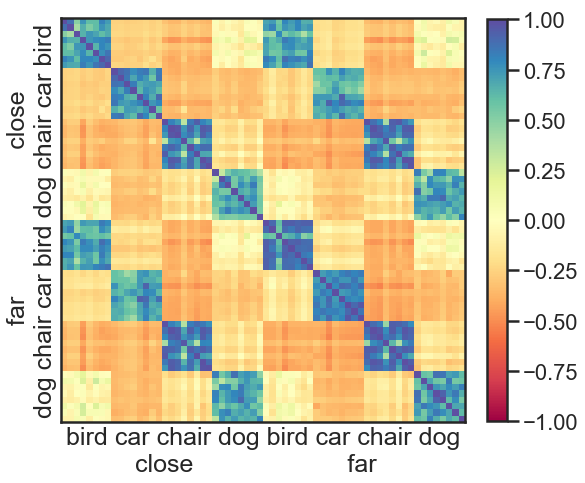

In [134]:
##Empirical matrix
c_means=[]
f_means=[]

for this_obj in ordered_objs:
    c_obj,f_obj,c_obj_list,f_obj_list = subset_dataframe_by_condition(F0,to_inspect='object', this_object=this_obj )
    c_mean = np.array(c_obj.mean())
    c_means.append(c_mean)
    f_mean = np.array(f_obj.mean())
    f_means.append(f_mean)
    
# c_means = np.apply_along_axis(softmax,1,np.vstack(c_means))  
# f_means = np.apply_along_axis(softmax,1,np.vstack(f_means))  
all_means = np.vstack((c_means,f_means))
#dmat = pdist(all_sample_means, 'correlation')
#dmat = squareform(dmat)
dmat = np.corrcoef(all_means)
plt.rcParams["axes.grid"] = False

plt.figure(figsize(8,8))
plt.matshow(dmat, cmap=plt.cm.Spectral,vmin=-1.,vmax=1.)
plt.colorbar(fraction=0.045)
#t = plt.xticks(range(len(ordered_objs)*2), close_far_labels, fontsize=10,rotation='vertical')
#t = plt.yticks(range(len(ordered_objs)*2), close_far_labels, fontsize=10)
plt.xticks([])
plt.yticks([])
plt.xlabel('bird car chair dog bird car chair dog\n  close                      far    ',\
          fontsize=25)
plt.ylabel('    far                     close\ndog chair car bird dog chair car bird',\
          fontsize=25)
plt.tick_params(axis='x',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='x',bottom=False,top=False,labelbottom=False)

### Bootstrapping for CI

In [135]:
mean_close_dists = []
mean_far_dists = []
mean_within_dists = []
mean_between_dists = []
cf_mean_diff = []
wb_mean_diff=[]
num_iters = 10 #Temporary low sampling number

In [136]:
for i in range(num_iters):
    c_sample_means=[]
    f_sample_means=[]

    for this_obj in ordered_objs:
        c_obj,f_obj,c_obj_list,f_obj_list = subset_dataframe_by_condition(F0,to_inspect='object', this_object=this_obj )
        c_indices = np.random.choice(c_obj.shape[0],size=c_obj.shape[0],replace=True) #sample with replacement
        c_sample = c_obj.iloc[c_indices]
        c_sample.reset_index(drop=True)
        f_indices= np.random.choice(f_obj.shape[0],size=f_obj.shape[0],replace=True) #sample with replacement
        f_sample =f_obj.iloc[f_indices]
        f_sample.reset_index(drop=True)


        c_mean = np.array(c_sample.mean())
        c_sample_means.append(c_mean)
        f_mean = np.array(f_sample.mean())
        f_sample_means.append(f_mean)

#     c_sample_means = np.apply_along_axis(softmax,1,np.vstack(c_sample_means))  
#     f_sample_means = np.apply_along_axis(softmax,1,np.vstack(f_sample_means))  
    c_sample_means = np.apply_along_axis(minmaxscale,1,np.vstack(c_sample_means))  
    f_sample_means = np.apply_along_axis(minmaxscale,1,np.vstack(f_sample_means))  
    all_sample_means = np.vstack((c_sample_means,f_sample_means))
    #dmat = pdist(all_sample_means, 'correlation')
    #dmat = squareform(dmat)
    dmat = np.corrcoef(all_sample_means)
    # plt.rcParams["axes.grid"] = False
    # plt.figure(figsize(8,8))
    # plt.matshow(dmat, cmap=plt.cm.Spectral,vmin=-1.,vmax=1.)
    # plt.colorbar(fraction=0.05)
    # t = plt.xticks(range(len(ordered_objs)*2), close_far_labels, fontsize=10,rotation='vertical')
    # t = plt.yticks(range(len(ordered_objs)*2), close_far_labels, fontsize=10)
    # plt.tick_params(axis='x',bottom=False,top=False,labelbottom=False)

    half_dim = int(dmat.shape[0]/2)
    cf_dmat= dmat[:half_dim,half_dim:]
    cc_dmat = dmat[:half_dim,:half_dim]
    ff_dmat = dmat[half_dim:,half_dim:]

    cat_dim = half_dim/4
    close_dists = []
    far_dists = []
    within_dists = []
    between_dists = []
    for catnum in range(len(unique_cats)):
        start_ind = int(cat_dim*catnum)
        end_ind = int(cat_dim*(catnum+1))
        f_cat_dmat = ff_dmat[start_ind:end_ind,start_ind:end_ind]
        c_cat_dmat = cc_dmat[start_ind:end_ind,start_ind:end_ind]
        cf_cat_dmat = cf_dmat[start_ind:end_ind,start_ind:end_ind]

        triu_inds = np.triu_indices(cat_dim,k=1)
        c_cat_dist = np.mean(c_cat_dmat[triu_inds])
        f_cat_dist = np.mean(f_cat_dmat[triu_inds])
        close_dists.append(c_cat_dist)
        far_dists.append(f_cat_dist)
        
         
        within_dists.append(np.mean(np.diag(cf_cat_dmat)))
        od_inds = np.where(~np.eye(cf_cat_dmat.shape[0],dtype=bool))
        between_dists.append(np.mean(cf_cat_dmat[od_inds]))
        
    mean_close_dists.append(np.mean(close_dists))
    mean_far_dists.append(np.mean(far_dists))
    cf_mean_diff.append(np.mean(far_dists)-np.mean(close_dists))
    mean_within_dists.append(np.mean(within_dists))
    mean_between_dists.append(np.mean(between_dists))
    wb_mean_diff.append(np.mean(within_dists)-np.mean(between_dists))
                            
                             

In [137]:
y_vals = [np.array(mean_close_dists).mean(),np.array(mean_far_dists).mean()]
spreadclose= np.percentile(mean_close_dists, 2.5),np.percentile(mean_close_dists, 97.5)
spreadfar = np.percentile(mean_far_dists,2.5),np.percentile(mean_far_dists, 97.5)
lower_err = np.array(mean_far_dists).mean()-spreadfar[0],np.array(mean_close_dists).mean()-spreadclose[0]
upper_err = spreadfar[1]-np.array(mean_far_dists).mean(),spreadclose[1]-np.array(mean_close_dists).mean()

errs= np.vstack((lower_err, upper_err))


([<matplotlib.axis.XTick at 0x120b76b90>,
 <a list of 2 Text xticklabel objects>)

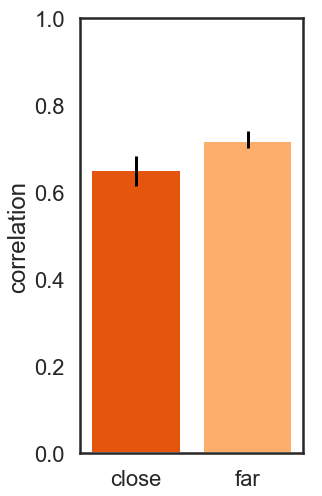

In [138]:
y_pos = np.arange(2)
fig = plt.figure(figsize=(4,8))
sns.set_context('poster')
colors = sns.color_palette('tab20c')
color_list = [colors[4],colors[6]]
plt.bar(y_pos,y_vals, yerr=errs,  width= 0.8, capsize=0,color=color_list)
plt.ylim((0.,1.))
plt.xlim((-0.5,1.5))
plt.ylabel('correlation')
plt.xticks(y_pos,['close','far'])
#plt.savefig(os.path.join(plot_dir,'close_far_dispersion.pdf'))

In [139]:
spreaddiff= np.percentile(cf_mean_diff,2.5),np.percentile(cf_mean_diff,97.5)
lower_err = np.array(cf_mean_diff).mean()-spreaddiff[0]
upper_err = spreaddiff[1]-np.array(cf_mean_diff).mean()
differrs = np.vstack((lower_err, upper_err))

Text(0,0.5,'close-far difference')

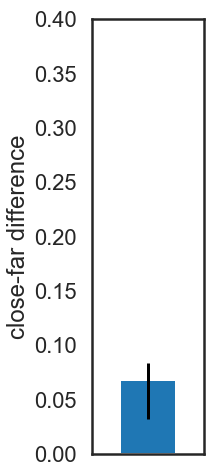

In [140]:
y_pos = 1
fig = plt.figure(figsize=(2,8))
plt.bar(y_pos,np.mean(cf_mean_diff), yerr= differrs, width= 0.5,capsize=0)
plt.ylim((0,0.4))
plt.xlim(0.5, 1.5)
plt.xticks([])
plt.ylabel('close-far difference')

[0.729554783712395, 0.6361981413911134]
[[0.01752623 0.01851702]
 [0.02146229 0.02828616]]


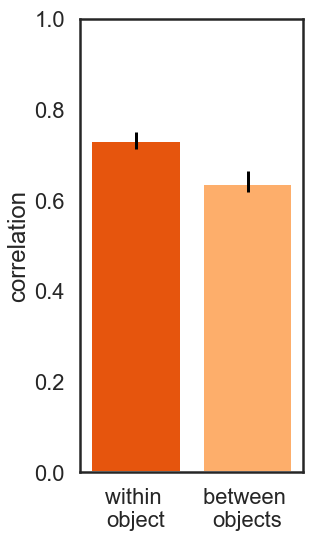

In [141]:
spreadwithin= np.percentile(mean_within_dists, 2.5),np.percentile(mean_within_dists, 97.5)
spreadbetween = np.percentile(mean_between_dists,2.5),np.percentile(mean_between_dists, 97.5)

lower_err = np.array(mean_within_dists).mean()-spreadwithin[0],np.array(mean_between_dists).mean()-spreadbetween[0]
upper_err = spreadwithin[1]-np.array(mean_within_dists).mean(),spreadbetween[1]-np.array(mean_between_dists).mean()

errs= np.vstack((lower_err, upper_err))

fig = plt.figure(figsize=(5,8))
sns.set_context('poster')
colors = sns.color_palette('tab20c')
color_list = [colors[4],colors[6]]
y_vals = [np.array(mean_within_dists).mean(),np.array(mean_between_dists).mean()]
print y_vals
print errs
y_pos = np.arange(2)
plt.bar(y_pos,y_vals, yerr= errs,  width= 0.8, capsize=0,color=color_list)
plt.ylim((0,1))
plt.xlim((-0.5,1.5))
plt.ylabel('correlation')
plt.xticks(y_pos,['within \nobject','between \nobjects'])
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir,'within_object_btw_context_similarity.pdf'))


Text(0,0.5,'Within-between difference')

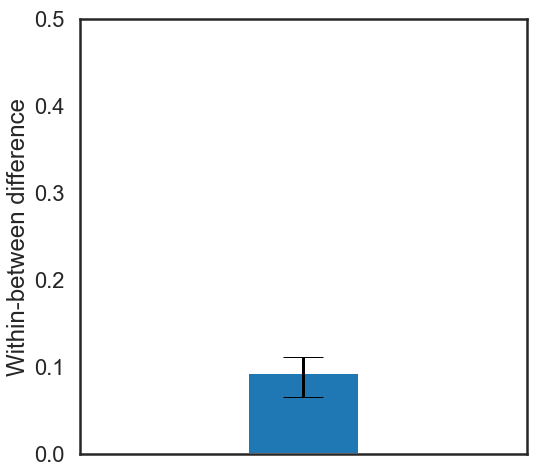

In [142]:
spreaddiff= np.percentile(wb_mean_diff,2.5),np.percentile(wb_mean_diff,97.5)
lower_err = np.array(wb_mean_diff).mean()-spreaddiff[0]
upper_err = spreaddiff[1]-np.array(wb_mean_diff).mean()
differrs = np.vstack((lower_err, upper_err))

y_pos = 1
plt.bar(y_pos,np.mean(wb_mean_diff), yerr= differrs, width= 0.5,capsize=20)
plt.ylim((0,0.5))
plt.xlim(0, 2)
plt.xticks([])
plt.ylabel('Within-between difference')

In [143]:
## get empirical difference vectors between close and far
d = get_context_difference_mat(F2)    
## measure sparsity of difference vectors
s = []
h = [] # entropy-based, need to softmax first... if you do the same before get_sparsity, very similar 
for i,_d in d.iterrows():
#     print '{} | sparsity: {} | entropy: {}'.format(ordered_objs[i], np.round(get_sparsity(softmax(_d)),4), entropy(softmax(_d.values)))
    s.append(get_sparsity(_d))
    h.append(entropy(softmax(_d.values)))
    
print 'Sparsity = 0 when all the values are identical (minimally sparse).'
print 'Sparsity = 1 when only one non-zero value (maximally sparse).'
print 'empirical sparsity| mu: {}, sd: {}'.format(np.mean(s),np.std(s))    


Sparsity = 0 when all the values are identical (minimally sparse).
Sparsity = 1 when only one non-zero value (maximally sparse).
empirical sparsity| mu: 0.652391564392, sd: 0.0819543998856


In [ ]:
### bootstrap resample to get 95% CIs on sparsity estimate
nIter = 1000
sboot_mean = []
for currIter in np.arange(nIter):
    print 'Running bootstrap iteration {} of {}'.format(currIter+1,nIter)
    clear_output(wait=True)
    Fboot = resample_sketches(F0,random_state=currIter)
    F2boot = aggregate_sketches(Fboot,OBJECT_TO_CATEGORY=OBJECT_TO_CATEGORY)
    dboot = get_context_difference_mat(F2boot)    
    sboot = dboot.apply(get_sparsity,axis=1)
    sboot_mean.append(np.mean(sboot.values))

Running bootstrap iteration 61 of 1000


In [ ]:
Sboot = pd.DataFrame(sboot_mean)
Sboot.columns=['sparsity']

In [ ]:
colors = sns.color_palette('tab20c')
sns.set_context('poster')
fig = plt.figure(figsize=(4,8))
mu = np.mean(sboot_mean)
lb = np.percentile(sboot_mean,2.5)
ub = np.percentile(sboot_mean,97.5)
plt.bar(0,mu,color=colors[4],width=0.3)
plt.errorbar(0,mu,
             yerr=np.vstack((mu-lb,ub-mu)),
             color='black',elinewidth=3)
wid = 0.3
plt.xlim(-wid,wid)
plt.ylim(0,1.)
plt.ylabel('sparsity',fontsize=22)
plt.xlabel(' ')
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir,'difference_vector_sparsity.pdf'))

In [ ]:
np.mean(sboot_mean).round(3)

In [ ]:
print lb,ub


### Apply PCA and visualize MDS plot

In [ ]:
## aggregate by target and condition and take the mean across rows within each group
F2 = F.groupby(['target','condition']).mean().reset_index()

## re-add category back to the F dataframe so we can subset on that later 
##( taking mean above removes it b/c it is a string)
F2['category'] = F2['target'].apply(lambda x: OBJECT_TO_CATEGORY[x])

## sort into standard order
F2 = F2.sort_values(['condition','category','target']).reset_index(drop=True)

## extract just the feature columns and store as np array
PF = np.array(F2[feat_cols])
## do the same for the meta
PM = F2.loc[:,['condition','category','target']]

# optionally apply PCA
apply_pca = True
num_pcs = 3
if apply_pca:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=num_pcs)
    pca.fit(PF)
    print('Applying PCA and transforming data, using {} components'.format(num_pcs))
    PF = pca.fit_transform(PF)

PF = pd.DataFrame(PF)    

## join into single dataframe for plotting
P = pd.concat([PF,PM],axis=1)

In [ ]:
sns.set_style('white')
sns.set_context('talk')
colors = sns.color_palette("husl", 5)
sns.scatterplot(data=P,
                x=0,
                y=1,
                hue='category',
                style='condition',
                palette=colors[:4])
plt.xlabel(' ')
plt.ylabel(' ')
axlim =  7
plt.xlim(-axlim,axlim)
# plt.xticks(np.arange(-axlim,axlim), 1.)
plt.ylim(-axlim,axlim)
plt.legend(bbox_to_anchor=(1.,1.))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir,'MDS_part_vectors.pdf'))